In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gap_statistic import OptimalK
try:
    from sklearn.datasets.samples_generator import make_blobs
except ImportError:
    from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import os

In [2]:
# task2vec2: combine member and material as one class
# task2vec: use separated material and member class
# task2vec_multi: copy tasks for demonstrataion and visualisation?

In [3]:
root = os.getcwd()
print('current base file: ', root)
work_data = os.path.join(root, 'data/task2vec_multi.csv')
data_work_df = pd.read_csv(work_data, header=0)
sample_num = data_work_df.shape[0]
print('there are {} data samples'.format(sample_num))

current base file:  C:\JupyterFiles\LDA
there are 363 data samples


In [4]:
map_dic_sp = {'None':0, 'Space':1, 'Plane':2, 'Storey':3, 'H_plane':4, 'V_plane':5, 'Ceil':6, 'Wall':7, 'Roof':8, 'Floor':9, 
              'Room_level_space':10, 'Story_level_space':11, 'Building_level_space':12}
map_dic_it = {'None':0, 'MEP_opening':1, 'Door':2, 'Window':3}
map_dic_mer = {'None':0, 'Product':1, 'Material':2, 'Furniture':3, 'Member':4, 'Board':5, 'MEP_Good':6,
              'Other_Good':7, 'Door':8, 'Window':9, 'Steel_Material':10, 'Welding_Material':11, 'Painting_Material':12,
              'Concrete_Material':13, 'Stud':14, 'Insulation_Material':15}
map_dic_lr = {'None':0, 'WL':1, 'PT':2, 'PL':3, 'TL':4, 'CL':5, 'RL':6} # None here means normal labour
map_dic = {'SP':map_dic_sp, 'IT':map_dic_it, 'MER':map_dic_mer, 'LR':map_dic_lr}
#map_dic = {'SP':map_dic_sp, 'MER':map_dic_mer, 'LR':map_dic_lr}

In [5]:
def generate_vec(data, dic, norm, split='/'):
    terms = data.split(split)
    vec = np.zeros(len(dic)).astype(int)
    for t in terms:
        idx = dic[t]
        vec[idx] = 1
    if norm==True:
        return normalization(vec)
    else:
        return vec

def normalization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

#def normalization(data):
#    _range = np.max(data) - np.min(data)
#    return (data - np.min(data)) / _range


In [6]:
norm=True
temp_data_list = []

for k, m in map_dic.items():
    print('processing feature: ', k)
    current_map = map_dic[k]
    temp_data = np.zeros((sample_num, len(current_map)))
    values = data_work_df[k].values
    
    for i in range(len(values)):
        # here we normalise features other than task dependencies, as they can produce unrealistic results
        # e.g., two tasks separated by many tasks are packaged together
        temp_vec = generate_vec(data_work_df[k].values[i], current_map, norm)
        temp_data[i] = temp_vec
    temp_data_list.append(temp_data)

processing feature:  SP
processing feature:  IT
processing feature:  MER
processing feature:  LR


In [7]:
# compute preceding and succeeding task as additional feature
print('processing feature: Task')
pre_data_temp = [a.split(',') for a in data_work_df['PRE'].values]
suc_data = list(data_work_df['SUC'].values)

pre_data = []
for p_data in pre_data_temp:
    pre_data.append(np.average(list(map(int, p_data))))

dep_vec = np.zeros((len(pre_data), 2))
for i in range(len(dep_vec)):
    dep_vec[i][0] = pre_data[i]
    dep_vec[i][1] = suc_data[i]

# NOTE here we do not normalise dependency to increase its weight
norm=False
if norm==True:
    temp_data_list.append(normalization(dep_vec))
else:
    temp_data_list.append(dep_vec)

# 拼接矩阵
# Feature sequence: SP, IT, MER, LR, TASK
data_k = np.hstack(temp_data_list)
print('The data for k-means: ', data_k.shape)
print('An example of the task vector: ', data_k[0])

processing feature: Task
The data for k-means:  (363, 42)
An example of the task vector:  [ 3.46410162 -0.28867513 -0.28867513 -0.28867513 -0.28867513 -0.28867513
 -0.28867513 -0.28867513 -0.28867513 -0.28867513 -0.28867513 -0.28867513
 -0.28867513  1.73205081 -0.57735027 -0.57735027 -0.57735027  3.87298335
 -0.25819889 -0.25819889 -0.25819889 -0.25819889 -0.25819889 -0.25819889
 -0.25819889 -0.25819889 -0.25819889 -0.25819889 -0.25819889 -0.25819889
 -0.25819889 -0.25819889 -0.25819889  2.44948974 -0.40824829 -0.40824829
 -0.40824829 -0.40824829 -0.40824829 -0.40824829  0.          2.        ]


### 结合手肘法和Gap-statistics寻找最佳K

C:\Users\40483\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


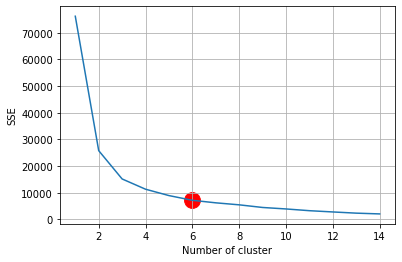

In [98]:
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k).fit(data_k)
    #data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.grid(True)
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.scatter(6, sse[6], s=250, c='r')
plt.show()

In [101]:
from collections import Counter

optimalK = OptimalK(parallel_backend='rust')
opt_clist = []
for i in range(50):
    n_clusters = optimalK(data_k, cluster_array=np.arange(1, 16)) # the algorithm returns a single int value for the number of clusters
    opt_clist.append(n_clusters)

collects = Counter(opt_clist)
most = collects.most_common(1)
print('Optimal clusters: ', most)
print(collects)

Optimal clusters:  [(15, 13)]
Counter({15: 13, 14: 13, 12: 11, 13: 7, 11: 3, 8: 2, 7: 1})


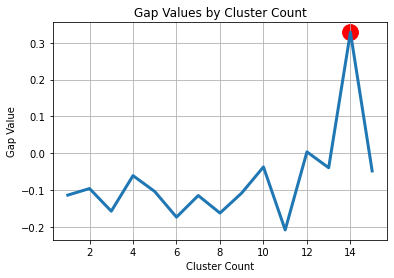

In [102]:
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

### 从两方面分析，综合结果取K=10

### 使用最佳的K运行K-means

In [8]:
km = KMeans(10)
km.fit(data_k)
km.labels_[:33]

array([9, 0, 0, 0, 0, 6, 6, 7, 7, 5, 5, 5, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4,
       1, 1, 1, 1, 8, 8, 8, 3, 3, 3, 3])

In [9]:
df = pd.DataFrame(data_k)
df['task_name'] = data_work_df['Task detail']
df['package'] = km.labels_
df[:33]

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,task_name,package
0,3.464102,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,...,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248,0.0,2.0,Board pretreatment and punching,9
1,-0.288675,-0.288675,3.464102,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,...,2.449490,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248,1.0,4.0,2D panel assembly,0
2,-0.288675,-0.288675,3.464102,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,...,2.449490,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248,1.0,4.0,Butt weld and fillet weld,0
3,-0.288675,3.464102,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,...,2.449490,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248,2.5,5.0,3D assembly,0
4,-0.288675,3.464102,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,...,-0.408248,2.449490,-0.408248,-0.408248,-0.408248,-0.408248,4.0,6.0,Apply fire paint at strucutral member,0
5,3.464102,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,...,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248,2.449490,5.0,7.0,Rebar Fixing,6
6,3.464102,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,-0.288675,...,-0.408248,-0.408248,-0.408248,-0.408248,2.449490,-0.408248,6.0,8.0,Pouring and curing Concrete,6
7,-0.547723,1.825742,-0.547723,-0.547723,-0.547723,1.825742,-0.547723,-0.547723,-0.547723,-0.547723,...,-0.408248,-0.408248,-0.408248,2.449490,-0.408248,-0.408248,7.0,10.0,Door frame installation,7
8,-0.547723,1.825742,-0.547723,-0.547723,-0.547723,1.825742,-0.547723,-0.547723,-0.547723,-0.547723,...,-0.408248,-0.408248,-0.408248,2.449490,-0.408248,-0.408248,7.0,10.0,Window frame installation,7
9,-0.666667,1.500000,-0.666667,-0.666667,1.500000,-0.666667,1.500000,-0.666667,-0.666667,-0.666667,...,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248,8.5,11.0,Stud installation at ceiling,5


### 测试阶段：
### 363条task数据 使用K-means聚类并结合PCA对K-means结合可视化

In [121]:
df_show = df.loc[:, list(np.arange(0, 42))]
df_show['label'] = df['package']

In [122]:
def pca(dataMat, topNfeat=999999):
    meanVals = np.mean(dataMat, axis=0)
    DataAdjust = dataMat - meanVals           #减去平均值
    covMat = np.cov(DataAdjust, rowvar=0)
    eigVals,eigVects = np.linalg.eig(np.mat(covMat)) #计算特征值和特征向量
    #print eigVals
    eigValInd = np.argsort(eigVals)
    eigValInd = eigValInd[:-(topNfeat+1):-1]   #保留最大的前K个特征值
    redEigVects = eigVects[:,eigValInd]        #对应的特征向量
    lowDDataMat = DataAdjust * redEigVects     #将数据转换到低维新空间
    reconMat = (lowDDataMat * redEigVects.T) + meanVals   #重构数据，用于调试
    return lowDDataMat, reconMat

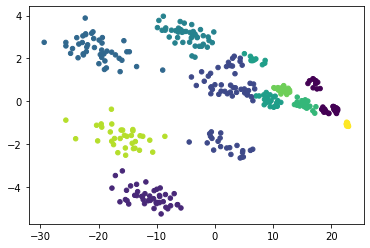

In [129]:
# randomly corrput the features (e.g., delete the leaf classes, randonly delete a single feature,
# such as its labour resources or preceding task)

x = np.array(df_show.iloc[:,0:-1])
rand = np.random.normal(1, 0.1, (x.shape[0], x.shape[1]))
x = x * rand

lowDMat, reconMat = pca(x, 2)
data_pca = np.real(lowDMat.A) # 2d
plt.scatter(data_pca[:,0], data_pca[:,1], s=20, c=df_show.label.values)

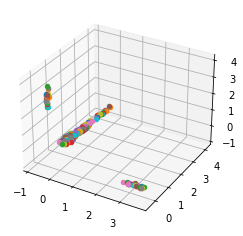

In [132]:
# 3D可视化(效果不好)
ax = plt.subplot(projection='3d')
for p in range(0, sample_num):
    y = df_show.label.values[p]
    ax.scatter((x[p, 0]), (x[p, 1]), (x[p, 2]))
plt.show()

In [109]:
from sklearn.metrics import silhouette_score 
from sklearn.metrics import calinski_harabasz_score

s_score = silhouette_score(df_show.iloc[:,0:-1], km.labels_)
print('silhouette score:', s_score)

c_score = calinski_harabasz_score(df_show.iloc[:,0:-1], km.labels_)
print('calinski_harabaz_score score:', c_score)

silhouette score: 0.5525511221420527
calinski_harabaz_score score: 726.5352988799482


In [112]:
for i in range(2,20):    
    kmeans = KMeans(n_clusters=i, random_state=123).fit(df_show.iloc[:,0:-1])    
    score = calinski_harabasz_score(df_show.iloc[:,0:-1], kmeans.labels_)    
    print('聚类%d簇的calinski_harabaz分数为：%f'%(i,score))

聚类2簇的calinski_harabaz分数为：706.067569
聚类3簇的calinski_harabaz分数为：724.740095
聚类4簇的calinski_harabaz分数为：686.325405
聚类5簇的calinski_harabaz分数为：674.667978
聚类6簇的calinski_harabaz分数为：690.447204
聚类7簇的calinski_harabaz分数为：655.623633
聚类8簇的calinski_harabaz分数为：663.787284
聚类9簇的calinski_harabaz分数为：711.155346
聚类10簇的calinski_harabaz分数为：718.472001
聚类11簇的calinski_harabaz分数为：787.603729
聚类12簇的calinski_harabaz分数为：803.383711
聚类13簇的calinski_harabaz分数为：923.406967
聚类14簇的calinski_harabaz分数为：977.226224
聚类15簇的calinski_harabaz分数为：1005.683917
聚类16簇的calinski_harabaz分数为：1053.701699
聚类17簇的calinski_harabaz分数为：1122.059867
聚类18簇的calinski_harabaz分数为：1210.532080
聚类19簇的calinski_harabaz分数为：1319.489794


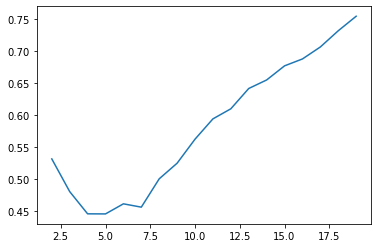

In [119]:
silhouettescore=[] 
for i in range(2,20):      
    kmeans=KMeans(n_clusters=i, random_state=123).fit(df_show.iloc[:,0:-1])      
    score=silhouette_score(df_show.iloc[:,0:-1], kmeans.labels_)
    silhouettescore.append(score)
    
plt.plot(range(2, 20),silhouettescore,linewidth=1.5,linestyle='-')
plt.show()